In [2]:
import numpy as np
import glets.gbd
import glets.raytrace as rt
import glets.utils as ut
from scipy.io import loadmat
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import poppy
import astropy.units as u

numexpr sees numcores =  8
numexpr sees numthreads =  8
numexpr sees max threads =  96
numba threads =  8


<Quantity 0.02083333>

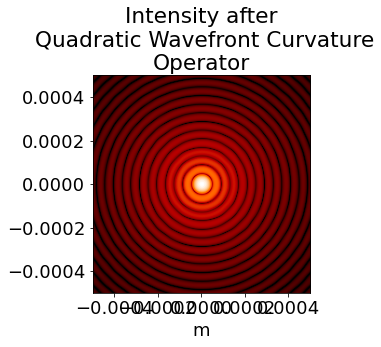

In [9]:
# Create a PSF
size = 2.4
efl = 57.6
wl = 1.65e-6
npix = 256

wf = poppy.FresnelWavefront(size/2*u.m,wavelength=wl,npix=npix,oversample=8)
circ = poppy.CircularAperture(radius=size/2*u.m)
lens = poppy.QuadraticLens(efl*u.m)

wf *= circ
wf *= lens
wf.propagate_fresnel(efl*u.m)
wf.display(scale='log',imagecrop=1e-3)

In [ ]:
def VortexCoronagraph(inwave):
    
    # There should be a kind of loop here to do multi-scale propagation, but let's just start with two
    size = 
    airy = 4*1.22*inwave.wavelength*(1/(2*inwave.divergence))
    psf = []
    obs = poppy.CircularAperture(radius=airy*u.m)
    
    wfin  = poppy.FresnelWavefront(size/2*u.m,wavelength=wl,npix=npix,oversample=8)
    wfout = poppy.FresnelWavefront(airy*u.m,wavelength=wl,npix=npix,oversample=8)
    
    for i in range(2):
        
        osys = poppy.FresnelOpticalSystem(npix=256)
        
        if i == 0:
            osys.add_optic(obs)
        elif i == 1:
            osys.add_optic(poppy.InverseTransmission(obs))
            
        osys.add_optic(ScalarVortexCoronagraph())
        osys.add_optic(poppy.QuadraticLens(57.6*u.m,name=' '),distance=57.6*u.m)

        # The Lyot Stop
        osys.add_optic(poppy.CircularAperture(radius=2.4/2*0.2*u.m,name='Lyot Stop'),distance=57.6*u.m)

        osys.add_optic(poppy.QuadraticLens(57.6*u.m,name=' '),distance=57.6*u.m)
        osys.add_optic(poppy.ScalarTransmission(name=' '),distance=57.6*u.m)
        
        psf.append(osys.calc_psf(wavelength=1.65e-6*u.m,inwave=wfarray,display_intermediates=False))
    
    
class ScalarVortexCoronagraph(AnalyticOpticalElement):
    
    def __init__(self, name="unnamed Scalar Vortex ",
                 wavelength=1e-6 * u.meter,
                 charge=2,
                 **kwargs):
        AnalyticOpticalElement.__init__(self, planetype=_INTERMED, **kwargs)
        self.name = name
        self.lp= charge
        self.central_wavelength= wavelength
        
    def getPhasor(self, wave):
        """
        Compute the amplitude transmission appropriate for a vortex for
        some given pixel spacing corresponding to the supplied Wavefront
        """

        if not isinstance(wave, Wavefront):  # pragma: no cover
            raise ValueError("AGPM getPhasor must be called with a Wavefront"
                             "to define the spacing")
        assert (wave.planetype == _IMAGE)

        y, x= self.get_coordinates(wave)
        phase = np.arctan2(y, x)

        AGPM_phasor = np.exp(1.j * self.lp * phase)

        idx= np.where(x==0)[0][0]
        idy= np.where(y==0)[0][0]
        AGPM_phasor[idx, idy]=0
        return AGPM_phasor

    def get_opd(self, wave):
        y, x= self.get_coordinates(wave)
        phase = np.arctan2(y, x)
        return self.lp * phase * self.central_wavelength.to(u.meter).value / (2 * np.pi)

    def get_transmission(self, wave):
        y, x= self.get_coordinates(wave)
        trans= np.ones(y.shape)
        return trans